import packages

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prepare_data import download_and_unzip, read_data
from IPython.display import IFrame
from scipy.stats import norm


Define input parameters.

In [115]:
years = [2024,
         # 2023,
         # 2022
        ]

assets_allocation = {'HASH11': 20000,
                     # 'SOLH11': 30000,
                     'ETHE11': 10000}

# Part I.

## Download and Read data.

In this section, we download historical yearly data from [B3's official website](https://www.b3.com.br/pt_br/market-data-e-indices/servicos-de-dados/market-data/historico/mercado-a-vista/series-historicas/) for market data. 

***Note**: The script automatically retrieves and processes data for the specified years.*

In [3]:
url = "https://www.b3.com.br/pt_br/market-data-e-indices/servicos-de-dados/market-data/historico/mercado-a-vista/series-historicas/"
IFrame(url, width="100%", height="600px")

⚠️ ***Note**: To Download and Unzip data uncomment this function*

In [4]:
# download_and_unzip(years)

Read data into dataframe.

In [5]:
data = read_data(years, data_dir="data")

print("\n")
if data is not None:
    print(data.head())
    print("Columns:", data.columns.tolist())
else:
    print("No data loaded.")

Reading data/2024/COTAHIST_A2024.TXT...


  TIPREG DATA_PREGAO CODBDI CODNEG TPMERC      NOMRES      ESPECI PRAZOT  \
0     01  2024-01-02     02  AALR3    010      ALLIAR  ON      NM    NaN   
1     01  2024-01-02     02  ABCB4    010  ABC BRASIL  PN  EJS N2    NaN   
2     01  2024-01-02     02  ABEV3    010   AMBEV S/A      ON  EJ    NaN   
3     01  2024-01-02     02  BBDC3    010    BRADESCO  ON  EJ  N1    NaN   
4     01  2024-01-02     02  ALPA3    010  ALPARGATAS  ON      N1    NaN   

  MODREF  PREABE  ...  TOTNEG    QUATOT       VOLTOT  PREEXE  INDOPC  \
0     R$   10.20  ...    1993    430400    401487500     0.0       0   
1     R$   23.98  ...    8964   1944700   4494730800     0.0       0   
2     R$   13.72  ...   16587  11690200  15983911100     0.0       0   
3     R$   15.26  ...    6674   4545600   6857685400     0.0       0   
4     R$   10.11  ...      20      2900      2912000     0.0       0   

     DATVEN  FATCOT  PTOEXE        CODISI  DISMES  
0  99991231     

## Filter and Preprocess Data.

In [116]:
def get_filtered_history(df, assets_allocation):
    # Filter the dataframe using the keys of assets_allocation
    filtered_df = df[df['CODNEG'].isin(assets_allocation.keys())].copy()

    pivot_df = filtered_df.pivot(index='DATA_PREGAO', columns='CODNEG', values='PREULT')
    pivot_df.sort_index(inplace=True)
    pivot_df = pivot_df.reindex(sorted(pivot_df.columns), axis=1)

    return pivot_df

In [117]:
df = get_filtered_history(data, assets_allocation)

df.head()

CODNEG,ETHE11,HASH11
DATA_PREGAO,,
2024-01-02,34.60,34.41
2024-01-03,32.71,33.31
2024-01-04,33.13,33.70
2024-01-05,32.79,33.49
2024-01-08,33.60,35.10


In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2024-01-02 to 2024-12-30
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ETHE11  251 non-null    float64
 1   HASH11  251 non-null    float64
dtypes: float64(2)
memory usage: 5.9 KB


In [119]:
df_melted = df.reset_index().melt(id_vars='DATA_PREGAO', 
                                           value_vars=assets_allocation.keys(), 
                                           var_name='CODNEG', 
                                           value_name='Price')

total_alloc = sum(assets_allocation.values())

df_portfolio = df[list(assets_allocation.keys())].mul(
    list(assets_allocation.values()), axis=1
).sum(axis=1) 

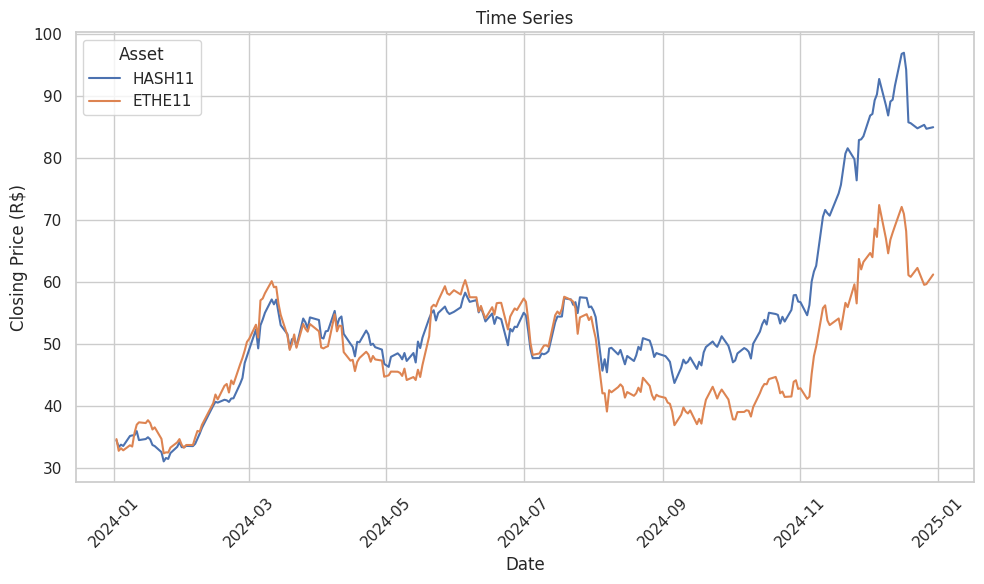

In [120]:
# sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_melted, x="DATA_PREGAO", y="Price", hue="CODNEG")

# Adding labels and title
plt.title("Time Series")
plt.xlabel("Date")
plt.ylabel("Closing Price (R$)")
plt.legend(title="Asset")
plt.xticks(rotation=45)  
plt.tight_layout()

plt.show()

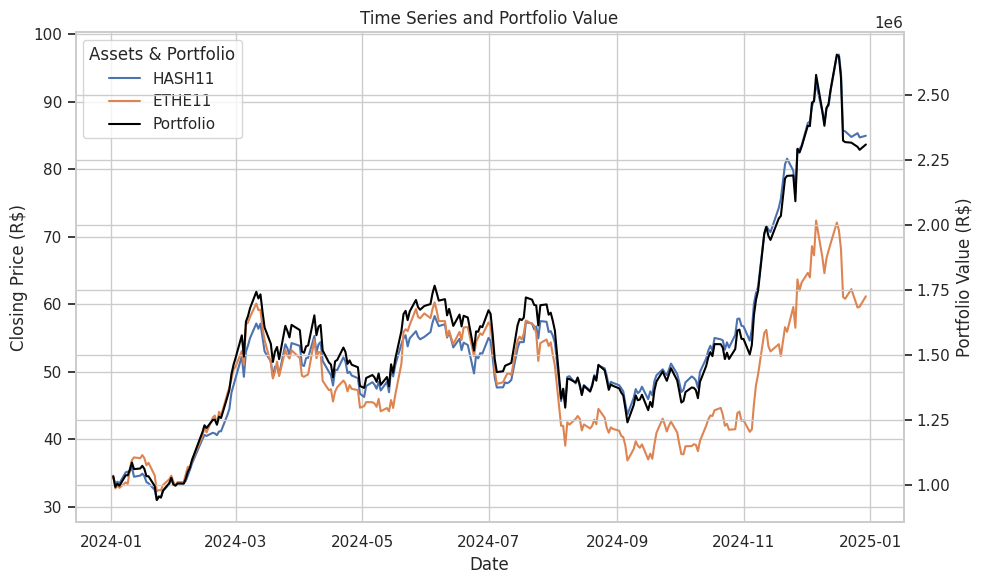

In [121]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plot the individual asset time series on the first y-axis (ax1)
sns.lineplot(data=df_melted, x="DATA_PREGAO", y="Price", hue="CODNEG", ax=ax1)
ax1.set_xlabel("Date")
ax1.set_ylabel("Closing Price (R$)")
ax1.set_title("Time Series and Portfolio Value")

# Plot the portfolio weighted average on the second y-axis (ax2)
ax2.plot(df_portfolio.index, df_portfolio, label='Portfolio', color='black')
ax2.set_ylabel("Portfolio Value (R$)")

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, title="Assets & Portfolio", loc='upper left')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Part II.

For constructing the VaR model, we use the following formulation:

$$
\mathrm{VaR_{daily}} = z_{\alpha} \times \sigma_{\mathrm{daily}}
$$

Where:
- $\alpha$: significance level (confidence = 1 - $\alpha$)
- $z_{\alpha}$: number of standard deviations corresponding to the given significance in a standard normal distribution $N(0,1)$
- $\sigma_{\mathrm{daily}}$: estimate of daily standard deviation

For computing $\sigma_{\mathrm{daily}}$ with $n$ assets:

$$
\sigma_{\mathrm{daily}}^2 = \omega^T \Sigma \omega
$$

where

$$
\omega =
\begin{pmatrix}
w_1 \\
w_2 \\
\vdots \\
w_n
\end{pmatrix}
\quad\text{and}\quad
\Sigma =
\begin{pmatrix}
\sigma_{11} & \sigma_{12} & \dots & \sigma_{1n} \\
\sigma_{21} & \sigma_{22} & \dots & \sigma_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
\sigma_{n1} & \sigma_{n2} & \dots & \sigma_{nn}
\end{pmatrix},
$$

with $\Sigma\$ being the covariance matrix.

Also, the EWMA (co)variance estimator is

$$
\sigma_{j,i,t+1 \mid t}^2 
= \lambda \times \sigma_{j,i,t \mid t-1}^2 
+ (1 - \lambda)\, r_{i,t}\, r_{j,t}
$$


$r_{i,t}$: daily return of asset $i$ at time $t$.

In [147]:
def compute_sigma_daily(assets_allocation: dict, df: pd.DataFrame, df_returns: pd.DataFrame, ewma_decay, initial_sigma=0.0):
    omega = pd.DataFrame()
    for asset, allocation in assets_allocation.items():
        omega[asset] = allocation * df[asset]

    n_times, n_assets = df.shape
    cov = np.zeros((n_assets, n_assets, n_times))
    for i in range(n_assets):
        for j in range(n_assets):
            cov[i, j, 0] = initial_sigma

    for t in range(n_times-1):
        for i in range(n_assets):
            for j in range(n_assets):  # TODO: compute only upper diagonal and then copy values
                cov[i, j, t+1] = ewma_decay * cov[i, j, t] + (1-ewma_decay) * df_returns.iloc[t, i] * df_returns.iloc[t, j]

    omega_array = omega.to_numpy()  # shape: (n_times, n_assets)
    sigma_daily = np.zeros(n_times)
    for t in range(n_times):
        sigma_daily[t] = omega_array[t].T @ cov[:, :, t] @ omega_array[t]

    return np.sqrt(sigma_daily)


def compute_daily_var(sigma_daily, alpha):
    # unilateral
    z_alpha = norm.ppf(1 - alpha)  # quantile (percent point function)

    # bilateral
    z_alpha_bilateral = norm.ppf(1 - alpha / 2)

    return z_alpha_bilateral * sigma_daily

In [166]:
ewma_decay = 0.5
initial_sigma = 0.0
alpha = 0.05

df_returns = df.pct_change().fillna(0)

sigma_daily = compute_sigma_daily(assets_allocation, df, df_returns, ewma_decay, initial_sigma)
# print("\nDaily Portfolio Standard Deviations:")
# print(sigma_daily)

daily_var = compute_daily_var(sigma_daily, alpha)
# print("\nDaily VaR:")
# print(daily_var)

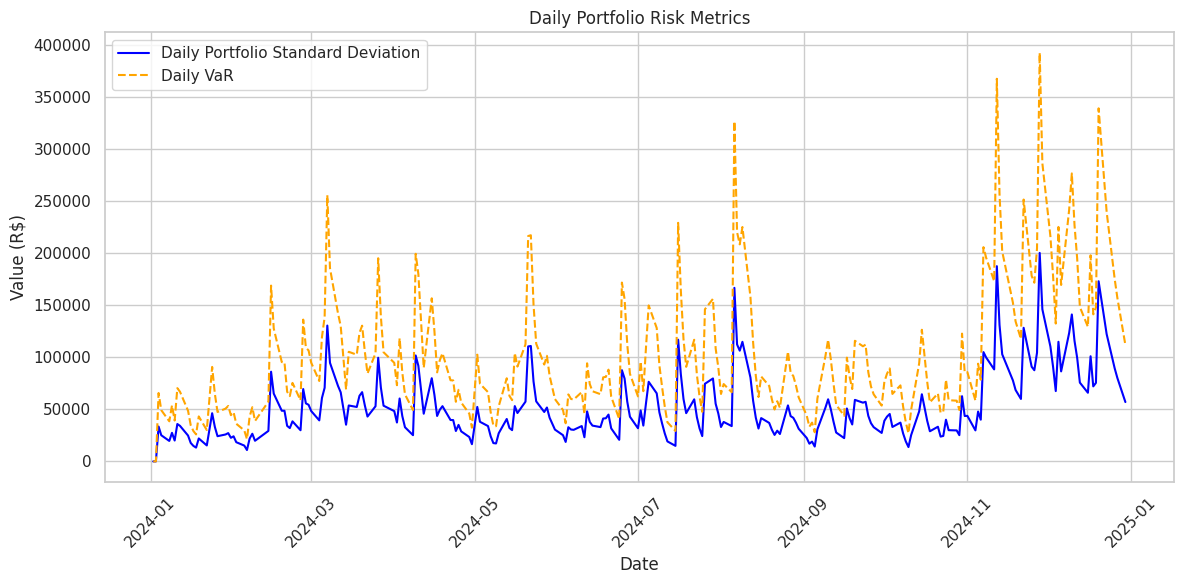

In [167]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, sigma_daily, label="Daily Portfolio Standard Deviation", color="blue")
plt.plot(df.index, daily_var, label="Daily VaR", linestyle="--", color="orange")
plt.title("Daily Portfolio Risk Metrics")
plt.xlabel("Date")
plt.ylabel("Value (R$)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()